In [10]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, rdMolTransforms, rdmolops
import os
import fnmatch
import numpy as np
import deepchem as dc
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GMM
import random
from tflearn.activations import leaky_relu
from deepchem.utils.rdkit_util import get_xyz_from_mol
from deepchem.feat.rdkit_grid_featurizer import convert_atom_to_voxel, compute_centroid, rotate_molecules
from tensorflow.contrib.distributions import Normal
np.set_printoptions(precision=4)


In [11]:
from deepchem.feat.graph_features import ConvMolFeaturizer
from deepchem.feat.adjacency_fingerprints import AdjacencyFingerprint

In [1073]:
def featurize_mols(mol_files, max_n_atoms, n_bonds=5, get_angle=True):
    featurizer = AdjacencyFingerprint(max_n_atoms=max_n_atoms)
    features = []
    for mol_idx, mol_file in enumerate(mol_files):
        if mol_idx % 32 == 0:
            print(mol_idx)
        try:
            if ".pdb" in mol_file:
                mol = Chem.MolFromPDBFile(mol_file)
            elif "mol" in mol_file:
                mol = Chem.MolFromMol2File(mol_file)
            else:
                get_angle = False
                mol = Chem.MolFromSmiles(mol_file)
            if mol is None:
                features.append(None)
                continue
            
            n_atoms = mol.GetNumAtoms()
            
            if get_angle:
                mol_xyz = get_xyz_from_mol(mol)
                centroid = compute_centroid(mol_xyz)
                mol_xyz -= centroid
                temp = np.zeros((max_n_atoms, 3))
                try:
                    temp[:mol_xyz.shape[0]] = mol_xyz
                except:
                    features.append(None)
                    continue
                mol_xyz = temp
                c = mol.GetConformer(0)

            else:
                mol_xyz = np.zeros((max_n_atoms,3))
                AllChem.EmbedMultipleConfs(mol, 1)
                c = mol.GetConformer(0)
                for aid in range(mol.GetNumAtoms()):
                    pos = c.GetAtomPosition(aid)
                    mol_xyz[aid] = [pos.x, pos.y, pos.z]

            torsions = []
            torsion_tuples = []

            torsion_matrix = np.zeros((n_bonds,1))
            torsion_indices = np.zeros((n_bonds, max_n_atoms, 4)).astype(np.uint8)
            subgraphs = np.zeros((n_bonds, max_n_atoms, max_n_atoms)).astype(np.uint8)
            atom_index_of_bond = np.zeros((n_bonds, max_n_atoms, 2)).astype(np.uint8)
            rot_vectors = np.zeros((n_bonds, 3))
            
            #mol_xyz = rotate_molecules([mol_xyz])[0]

            idx = 0
            for bond in mol.GetBonds():
                if bond.IsInRing(): 
                    continue
                def calc_torsions(atom_i, atom_j, bond_idx):        
                    exist_dihed = False
                    for neighbor_j in atom_j.GetNeighbors():
                        if neighbor_j.GetIdx() == atom_i.GetIdx():
                            continue

                        dihed_idx = 0
                        for neighbor_i in atom_i.GetNeighbors():
                            if neighbor_i.GetIdx() == atom_j.GetIdx():
                                continue

                            exist_dihed=True
                            torsion_tuple = (neighbor_i.GetIdx(), atom_i.GetIdx(), atom_j.GetIdx(), neighbor_j.GetIdx())

                            if get_angle:
                                torsion_matrix[bond_idx][dihed_idx] = rdMolTransforms.GetDihedralRad(c, *torsion_tuple)
                            torsion_indices[bond_idx][torsion_tuple[0]][dihed_idx*4] = 1
                            torsion_indices[bond_idx][torsion_tuple[1]][dihed_idx*4+1] = 1
                            torsion_indices[bond_idx][torsion_tuple[2]][dihed_idx*4+2] = 1
                            torsion_indices[bond_idx][torsion_tuple[3]][dihed_idx*4+3] = 1
                            
                            broken_mol = rdmolops.FragmentOnBonds(mol, [bond.GetIdx()], addDummies=False)
                            molfrags = rdmolops.GetMolFrags(broken_mol)
                            if bond.GetEndAtom().GetIdx() in molfrags[0]:
                                atoms_to_rotate = molfrags[0]
                            else:
                                atoms_to_rotate = molfrags[1]


                            subgraph = np.zeros((max_n_atoms, max_n_atoms)).astype(np.uint8)
                            for atom_idx in atoms_to_rotate:
                                subgraph[atom_idx,atom_idx] = 1
                            subgraphs[bond_idx, :, :] = subgraph
                            atom_index_of_bond[bond_idx, atom_j.GetIdx(), 0] = 1
                            atom_index_of_bond[bond_idx, atom_i.GetIdx(), 1] = 1
                            
                            pos_i = c.GetAtomPosition(atom_i.GetIdx())
                            pos_j = c.GetAtomPosition(atom_j.GetIdx())
                            pt_i = np.array([pos_i.x, pos_i.y, pos_i.z])
                            pt_j = np.array([pos_j.x, pos_j.y, pos_j.z])
                            vec = pt_j - pt_i
                            vec = vec / np.linalg.norm(vec)
                
                            bond_idx += 1
                        break
                    return(bond_idx)
                
                if idx >= n_bonds: 
                    break
                idx = calc_torsions(bond.GetBeginAtom(), bond.GetEndAtom(), idx)
            
            if idx == 0:
                features.append(None)
                continue 
            for i in range(idx, n_bonds):
                atom_index_of_bond[i] = atom_index_of_bond[idx-1]
                
                
            graph_feat = featurizer.featurize([mol])[0]           
            features.append((mol_file, mol_xyz, torsion_indices, torsion_matrix, subgraphs, atom_index_of_bond, n_atoms, graph_feat))
        except:
            features.append(None)
    return(features)

In [1276]:
import pickle
max_n_atoms = 24
D=10
S=32
feature_file = "./dihed_xyz_features_pdbbind2.pkl"
#if not os.path.exists(feature_file):
if 1== 1:
    pdbbind_dir = "/home/evan/Documents/deep_docking/datasets/v2015/"
    def find_files(directory, pattern):
        for root, dirs, files in os.walk(directory):
            for basename in files:
                if fnmatch.fnmatch(basename, pattern):
                    filename = os.path.join(root, basename)
                    yield filename
    ligand_files = []
    for f in find_files(pdbbind_dir, "*ligand.mol2"):
        ligand_files += [f]
    ligand_files = ligand_files[:] + ["CCCC"]*32 #["/home/evan/Documents/deep_docking/alanine_dipeptide.pdb"]*S  
    features = featurize_mols(ligand_files, max_n_atoms, n_bonds=D)
    with open(feature_file, "wb") as f:
        pickle.dump(features, f, protocol=2)
else:
    with open(feature_file, "rb") as f:
        features = pickle.load(f)

0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992
1024
1056
1088
1120
1152
1184
1216
1248
1280
1312
1344
1376
1408
1440
1472
1504
1536
1568
1600
1632
1664
1696
1728
1760
1792
1824
1856
1888
1920
1952
1984
2016
2048
2080
2112
2144
2176
2208
2240
2272
2304
2336
2368
2400
2432
2464
2496
2528
2560
2592
2624
2656
2688
2720
2752
2784
2816
2848
2880
2912
2944
2976
3008
3040
3072
3104
3136
3168
3200
3232
3264
3296
3328
3360
3392
3424
3456
3488
3520
3552
3584
3616
3648
3680
3712
3744
3776
3808
3840
3872
3904
3936
3968
4000
4032
4064
4096
4128
4160
4192
4224
4256
4288
4320
4352
4384
4416
4448
4480
4512
4544
4576
4608
4640
4672
4704
4736
4768
4800
4832
4864
4896
4928
4960
4992
5024
5056
5088
5120
5152
5184
5216
5248
5280
5312
5344
5376
5408
5440
5472
5504
5536
5568
5600
5632
5664
5696
5728
5760
5792
5824
5856
5888
5920
5952
5984
6016
6048
6080
6112
6144
6176
6208
6240
6272
6304
6336
6368
6400
6432
6464
6496
6528
6560
6592
66

In [1277]:
features = [f for f in features if f is not None]
print(len(features))

3662


In [1278]:
features[3]

('/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2',
 array([[-0.0725, -0.0715, -1.7212],
        [-0.8925,  0.3145, -0.4713],
        [-0.2245, -0.1035,  1.0027],
        [ 1.1895, -0.1395,  1.1898],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ]]),
 array([[[1, 0, 0, 0],
         [0,

In [1279]:
import tensorflow as tf
tf.reset_default_graph()

alpha = 0.01
n_layers = 1


S = 32

B = max_n_atoms

D = 10
p = 75

z_dim = 32

L_list = [p, 16, 64, 128, 256]

dihed_per_bond = 1
valence = 4



In [1280]:
#with tf.device('/gpu:0'):
if 1==1:
    x = tf.placeholder(tf.float32, [S, B, L_list[0]], name="atom_features")
    n_atoms = tf.placeholder(tf.int32, [S, 1], name="n_atoms")
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    
    adj_matrix = tf.placeholder(tf.float32, shape=[S, B, B], name="adj_matrix")
    
    non_adj_matrix = tf.subtract(tf.ones_like(adj_matrix), adj_matrix)
    
    mol_xyz = tf.placeholder(tf.float32, shape=[S, B, 3], name="molxyz")
    
    z = tf.random_uniform([S, D, z_dim], -1, 1)
    zg = tf.random_uniform([S, D], -2, 2)
    
    mol_noise = tf.random_normal([S,D,1], mean=0,stddev=0.01)
    
    dihed_indices = tf.placeholder(tf.float32, shape=[S, D, B, 4])
    dihed_tensor = tf.placeholder(tf.float32, shape=[S, D, 1])
    rot_vectors = tf.placeholder(tf.float32, shape=[S, D, 3])
    atom_index_of_bond = tf.placeholder(tf.float32, shape=[S, D, B, 2])
    subgraph = tf.placeholder(tf.float32, shape=[S, D, B, B])
    
    phase = tf.placeholder(tf.bool)


In [1281]:
#adapted from: http://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
def compute_distance_matrix(A):
    r = tf.reduce_sum(A*A, 1) # turn r into column vector 
    r = tf.reshape(r, [-1, 1]) 
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return(D)

In [1282]:
GW_list = [None for i in range(n_layers)]
Gb_list = [None for i in range(n_layers)]

DW_list = [None for i in range(n_layers)]
Db_list = [None for i in range(n_layers)]


Gh_list = [x]
Dh_list = [x]

adj_list = [adj_matrix]
B_list = [B]
clades_list = []
graph_stride = 1.

#with tf.device('/gpu:0'):
if 1==1:

    print("building clades and adj")
    for i in range(n_layers):
        print(i)
        B_list.append(int(np.ceil(B_list[i]/graph_stride)))
        print(B_list)
        clades_list.append(tf.stack([tf.one_hot(range(0,B_list[i],int(graph_stride)), depth=B_list[i])]*S, axis=0)) 


        adj_temp = tf.matmul(clades_list[i], adj_list[i])
        sub_adj = tf.matmul(adj_temp, tf.transpose(adj_temp, perm=[0, 2, 1]))
        sub_adj = tf.minimum(sub_adj, 1.)
        adj_list.append(sub_adj)

    print("Building hidden layers")
    for layer_idx in range(n_layers):
        GW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="GW_list%d" %layer_idx)
        Gb_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))

        DW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="DW_list%d" %layer_idx)
        Db_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))

    f_dw1 = tf.Variable(tf.truncated_normal([L_list[n_layers], L_list[n_layers]]), name="f_dw1")
    f_db1 = tf.Variable(tf.ones([L_list[n_layers]]))

    f_gw1 = tf.Variable(tf.truncated_normal([L_list[n_layers], L_list[n_layers]]))
    f_gb1 = tf.Variable(tf.ones([L_list[n_layers]]))

    g_w1_ini = tf.Variable(tf.truncated_normal([1, L_list[n_layers]*5+z_dim, 16], stddev=1.))
    g_w1 = tf.tile(g_w1_ini, [S, 1, 1])
    g_g1 = tf.Variable(tf.ones([1,1,16]))

    g_b1 = tf.Variable(tf.ones([1, 1, 16]))

    g_w2_ini = tf.Variable(tf.truncated_normal([1, 16, 16], stddev=1.))
    g_w2 = tf.tile(g_w2_ini, [S, 1, 1])
    g_g2 = tf.Variable(tf.ones([1,1,16]))

    g_b2 = tf.Variable(tf.ones([1, 1, 16]))

    g_w3_ini = tf.Variable(tf.truncated_normal([1, 16, 15], stddev=1.))
    g_w3 = tf.tile(g_w3_ini, [S, 1, 1])
    g_b3 = tf.Variable(tf.ones([1, 1, 15]))
    g_g3 = tf.Variable(tf.ones([1,1,1]))

    dd_w1_ini = tf.Variable(tf.truncated_normal([1, L_list[n_layers]*5+1, 32]))
    dd_w1 = tf.tile(dd_w1_ini, [S, 1, 1])
    dd_b1 = tf.Variable(tf.truncated_normal([1, 1, 32]))

    dd_w2_ini = tf.Variable(tf.truncated_normal([1,32, 32]))
    dd_w2 = tf.tile(dd_w2_ini, [S, 1, 1])
    dd_b2 = tf.Variable(tf.truncated_normal([1,1,32]))

    dd_w3_ini = tf.Variable(tf.truncated_normal([1,32, 1]))
    dd_w3 = tf.tile(dd_w2_ini, [S, 1, 1])
    dd_b3 = tf.Variable(tf.truncated_normal([1,1,1]))
    
    
    d_w1_ini = tf.Variable(tf.truncated_normal([1, B*(L_list[n_layers]*2+1), 32]))
    d_w1 = tf.tile(d_w1_ini, [S, 1, 1])
    d_b1 = tf.Variable(tf.ones([1, 1, 32]))

    d_w2_ini = tf.Variable(tf.truncated_normal([1, 32, 1]))
    d_w2 = tf.tile(d_w2_ini, [S, 1, 1])
    d_b2 = tf.Variable(tf.ones([1, 1, 1]))

    lam1 = tf.Variable(tf.constant(-1.))
    lam2 = tf.Variable(tf.constant(3.))
    lam3 = tf.Variable(tf.constant(0.01))

building clades and adj
0
[24, 24]
Building hidden layers


In [1283]:
def adjacency_conv_layer(x, W, b, adj, clades, L_in, L_out, layer_idx, S, B):
    with tf.device('/gpu:0'):
        print("layer_idx: %d" %(layer_idx))
        h = tf.matmul(adj, x, name="adj_mult_%d" %layer_idx)
        h = tf.reshape(h, shape=(S*B, L_in), name="adj_reshape_1_%d" %layer_idx)

        h = tf.matmul(h, W, name="adjconv_%d" %layer_idx) + b
    
        h = tf.nn.tanh(h)
        h = tf.reshape(h, (S, B, L_out), name="adj_reshape_2_%d" %layer_idx)  

        h = tf.matmul(clades, h)

        print("within func h:")
        print(h)                                                                                                                              

    return(h)

In [1284]:
#t = sess.run(tf.matmul(dihed_indices[:,:,:,0], x))
#t = np.reshape(t, [t.shape[0]*t.shape[1],t.shape[2]])

In [1285]:
def compute_angle_tensor(mols_batch, angle_tuples_batch):
    i_vec = tf.reshape(mols_batch, [S, B, 1, 3])
    i_vec = tf.tile(i_vec, [1, 1, B, 1])

    j_vec = tf.reshape(mols_batch, [S, 1, B, 3])
    j_vec = tf.tile(j_vec, [1, B, 1, 1])

    diff = tf.subtract(i_vec, j_vec)
    temp = tf.eye(B, batch_shape=[S])
    temp = tf.reshape(temp, [S, B, B, 1])
    temp = tf.tile(temp, [1, 1, 1, 3])
    diff = diff + temp
    diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))
    temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))
    diff = tf.subtract(diff, temp)

    print("diff should be [S, B, B, 3]")
    print(diff)

    ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])
    ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])
    dps = tf.reduce_sum(tf.multiply(ij ,ik), axis=4)
    #dps = tf.where(tf.is_nan(dps), tf.ones_like(dps) * 0., dps)
    print("dps should be [S, B, B, B]")
    print(dps)

    #angles_gen = tf.acos(tf.clip_by_value(dps, -1.0, 1.0))
    angles_computed = tf.where(tf.is_nan(dps), tf.zeros_like(dps), dps)
    angles_computed = tf.multiply(angles_computed, angle_tuples_batch)
    return(angles_computed)

def compute_dist_tensor(mols_batch):
    dist_matrix = tf.concat([tf.reshape(compute_distance_matrix(tf.reshape(mol, [B, 3])), (1, B, B)) for mol in tf.split(mols_batch, S, axis=0)], axis=0)
    #dist_matrix = tf.where(tf.is_nan(dist_matrix), tf.ones_like(dist_matrix) * 0., dist_matrix)
    print("dist_matrix")
    print(dist_matrix)
    #dist_matrix = compute_distance_matrix(mol)
    return(dist_matrix)

def compute_rot_matrices(t, vec):
    t = tf.squeeze(t)
    x, y, z = vec[:, 0], vec[:, 1], vec[:,2]
    rot_matrix = tf.reshape(tf.transpose(tf.stack([tf.cos(t) + tf.square(x) * (1 - tf.cos(t)), 
                               x*y*(1-tf.cos(t)) - z*tf.sin(t),
                               x*z*(1-tf.cos(t)) + y*tf.sin(t),
                              y*x*(1-tf.cos(t)) + z*tf.sin(t),
                               tf.cos(t) + y*y*(1-tf.cos(t)),
                               y*z*(1-tf.cos(t)) - x*tf.sin(t),
                              z*x*(1-tf.cos(t)) - y*tf.sin(t),
                               z*y*(1-tf.cos(t)) + x*tf.sin(t),
                               tf.cos(t)+ z*z*(1-tf.cos(t))])), (S, 3, 3))
    print("rot_matrix")
    print(rot_matrix)

    return(rot_matrix)

def compute_rot_matrix(t, vec):
    t = tf.squeeze(t)
    x, y, z = vec[0, 0], vec[0, 1], vec[0, 2]
    rot_matrix = tf.reshape(tf.transpose(tf.stack([tf.cos(t) + tf.square(x) * (1 - tf.cos(t)), 
                               x*y*(1-tf.cos(t)) - z*tf.sin(t),
                               x*z*(1-tf.cos(t)) + y*tf.sin(t),
                              y*x*(1-tf.cos(t)) + z*tf.sin(t),
                               tf.cos(t) + y*y*(1-tf.cos(t)),
                               y*z*(1-tf.cos(t)) - x*tf.sin(t),
                              z*x*(1-tf.cos(t)) - y*tf.sin(t),
                               z*y*(1-tf.cos(t)) + x*tf.sin(t),
                               tf.cos(t)+ z*z*(1-tf.cos(t))])), (3, 3))
    print("rot_matrix")
    print(rot_matrix)

    return(rot_matrix)


"""
def compute_dihedral_tensor(mols_batch, angle_tuples_batch):
    i_vec = tf.reshape(mols_batch, [S, B, 1, 3])
    i_vec = tf.tile(i_vec, [1, 1, B, 1])

    j_vec = tf.reshape(mols_batch, [S, 1, B, 3])
    j_vec = tf.tile(j_vec, [1, B, 1, 1])

    diff = tf.subtract(i_vec, j_vec)
    temp = tf.eye(B, batch_shape=[S])
    temp = tf.reshape(temp, [S, B, B, 1])
    temp = tf.tile(temp, [1, 1, 1, 3])
    diff = diff + temp
    diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))
    temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))
    diff = tf.subtract(diff, temp)

    print("diff should be [S, B, B, 3]")
    print(diff)

    ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])
    ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])
    cross = tf.cross(ij, ik)
    cross = cross / tf.sqrt(tf.reduce_sum(tf.square(cross), axis=4, keep_dims=True))
    
    ijk = tf.tile(tf.reshape(cross, [S, B, B, 1, B, 3]), [1m 1])
    
    dps = tf.reduce_sum(tf.multiply(ij ,ik), axis=4)
    #dps = tf.where(tf.is_nan(dps), tf.ones_like(dps) * 0., dps)
    print("dps should be [S, B, B, B]")
    print(dps)

    #angles_gen = tf.acos(tf.clip_by_value(dps, -1.0, 1.0))
    angles_computed = tf.where(tf.is_nan(dps), tf.zeros_like(dps), dps)
    angles_computed = tf.multiply(angles_computed, angle_tuples_batch)
    return(angles_computed)
"""

'\ndef compute_dihedral_tensor(mols_batch, angle_tuples_batch):\n    i_vec = tf.reshape(mols_batch, [S, B, 1, 3])\n    i_vec = tf.tile(i_vec, [1, 1, B, 1])\n\n    j_vec = tf.reshape(mols_batch, [S, 1, B, 3])\n    j_vec = tf.tile(j_vec, [1, B, 1, 1])\n\n    diff = tf.subtract(i_vec, j_vec)\n    temp = tf.eye(B, batch_shape=[S])\n    temp = tf.reshape(temp, [S, B, B, 1])\n    temp = tf.tile(temp, [1, 1, 1, 3])\n    diff = diff + temp\n    diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))\n    temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))\n    diff = tf.subtract(diff, temp)\n\n    print("diff should be [S, B, B, 3]")\n    print(diff)\n\n    ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])\n    ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])\n    cross = tf.cross(ij, ik)\n    cross = cross / tf.sqrt(tf.reduce_sum(tf.square(cross), axis=4, keep_dims=True))\n    \n    ijk = tf.tile(tf.reshape(cross, [S, B, 

In [1286]:
def wnorm_layer(w, x, gamma, alpha):
    axes = range(0, len(w.get_shape()))
    wn = tf.nn.l2_normalize(w, -1)*gamma
    y = tf.nn.tanh(tf.matmul(x, wn) - alpha) + alpha
    return(y)

In [1287]:
def generator(W_list, b_list, h_list, L_list, n_layers, mols):
    if 1==1:
    #with tf.device('/gpu:0'):
    #with tf.variable_scope("generator"):
        for layer_idx in range(n_layers):
            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                                         b_list[layer_idx], adj_list[layer_idx], 
                                                         clades_list[layer_idx],
                                                         L_list[layer_idx], L_list[layer_idx+1],
                                                         layer_idx, S, B_list[layer_idx]), keep_prob))
        L_final = L_list[n_layers]  

        print("h_list[-1]")
        print(h_list[-1])

        print("B_list")
        print(B_list)

        fingerprints = tf.tile(tf.reshape(tf.nn.tanh(tf.matmul(tf.reduce_sum(h_list[-1], axis=1), f_gw1) + f_gb1), [S, 1, L_final]), [1, D, 1])

        #fingerprints = tf.tile(tf.reshape(tf.layers.batch_normalization(tf.nn.tanh(tf.matmul(tf.reduce_sum(h_list[-1], axis=1), f_gw1) + f_gb1), training=phase, name="gbn1"), [S, 1, L_final]), [1, D, 1])
        h_final = h_list[-1]

        d0 = []
        for l in range(0, valence*dihed_per_bond):
            d0.append(tf.matmul(dihed_indices[:,:,:,l], h_final, name="dihed_mult"))

        d0 = tf.concat(d0, axis=2)
        print("d0 should be shape %s" %(str((S, D, L_list[n_layers]*4))))
        d0 = tf.concat([d0, fingerprints, z], axis=2)

        #PREDICT ANGLES:
        g_h1 = tf.nn.dropout(tf.nn.tanh(tf.matmul(d0, g_w1) + g_b1), keep_prob)
        #g_h1 = wnorm_layer(g_w1, d0, g_g1, g_b1)
        #g_h1 = tf.nn.tanh(tf.matmul(d0, wnorm(g_w1, g_g1)) + g_b1)
        #g_h1 = tf.reshape(g_h1, [S, 5, 16])
        print("g_h1")
        print(g_h1)
        #g_h2 = tf.nn.dropout(tf.nn.tanh(tf.matmul(g_h1, g_w2) + g_b2), 1.)
        g_h2 = tf.nn.dropout(tf.nn.tanh(tf.matmul(g_h1, g_w2)+g_b2), keep_prob)
        
        print("g_h2")
        print(g_h2)
        
        #g_h2 = wnorm_layer(g_w2, g_h1, g_g2, g_b2)
        
        g_h3 = tf.reshape(tf.matmul(g_h2, g_w3) + g_b3, [S, D, 15])
        #g_h3 = wnorm_layer(g_w3, g_h2, g_g3, g_b3)
        
        print("g_h3")
        print(g_h3)
        #g_h3 = tf.atan2(tf.sin(g_h3), tf.cos(g_h3))

        def sample_gen_cdf(params, noise):
            angle = 0.
            for i in range(0,5):
                comp = tf.nn.tanh(tf.add(tf.multiply(params[:,:,i*3+1], noise), params[:,:,i*3+2]))
                print("comp1")
                print(comp)
                comp = tf.multiply(tf.clip_by_value(params[:,:,i*3], 0.0, 1.0), comp)
                print("comp2")
                print(comp)
                angle = tf.add(angle, comp)
            return(angle)
        
        output = sample_gen_cdf(g_h3, zg)
        output = tf.reshape(output, [S, D,1])

        """
        new_mols = []
        for i in range(0,S):
            mol = mol_xyz[i]
            for j in range(0,D):
                rot_point = tf.matmul(tf.reshape(atom_index_of_bond[i,j,:], (1, B)), mol)
                mol = tf.subtract(mol, rot_point)
                rot_mat = compute_rot_matrix(tf.subtract(g_h3[i, j], dihed_tensor[i, j]), rot_vectors[i, j])
                if i ==0 and j ==0:
                    rot_mat_r = rot_mat

                frag_i = tf.transpose(tf.matmul(subgraph[i, j, :, :], mol), perm=[1,0])
                new_xyz = tf.transpose(tf.matmul(rot_mat, frag_i), perm=[1,0])

                other_subgraph = tf.subtract(tf.eye(B), subgraph[i, j, :, :])
                mol = tf.add(new_xyz, tf.matmul(other_subgraph, mol))
            new_mols.append(mol)
        rot_mols = tf.stack(new_mols, axis=0)

        #ROTATE MOLECULE: 
        rot_mols = []
        #(S, B, 3)
        for i in range(0, S):
            rot_mol = mols[i]
            for j in range(0,10):
                #atom_index_of_bond[:, j, :, 0] should be (S, 1, B)
                #
                rot_points = tf.matmul(tf.reshape(atom_index_of_bond[i, j, :, 0], (1, B)), rot_mol)
                rot_mol = rot_mol - rot_points
                rot_vecs = tf.reshape(tf.matmul(tf.reshape(atom_index_of_bond[i, j, :, 0], (1, B)), rot_mol) - tf.matmul(tf.reshape(atom_index_of_bond[i, j, :, 1], (1, B)), rot_mol), (1, 3))
                rot_vecs = rot_vecs / tf.norm(rot_vecs)
                rot_mat = compute_rot_matrix(tf.subtract(output[i, j], dihed_tensor[i, j]), rot_vecs)
                if j == 0:
                    rot_mat_r = rot_mat
                    rot_points_r = rot_points
                    rot_vecs_r = rot_vecs

                frag_i = tf.transpose(tf.matmul(subgraph[i, j, :, :], rot_mol), perm=[1, 0])
                frag_i_xyz = tf.transpose(tf.matmul(rot_mat, frag_i), perm=[1,0])
                other_subgraph = tf.subtract(tf.eye(B), subgraph[i, j, :, :])
                rot_mol = tf.add(frag_i_xyz, tf.matmul(other_subgraph, rot_mol))
            rot_mols.append(rot_mol)
        rot_mols = tf.stack(rot_mols, axis=0)
        
        
        """
        rot_mols = mols
        #(S, B, 3)
        for j in range(0,D):
            #atom_index_of_bond[:, j, :, 0] should be (S, 1, B)
            #
            rot_points = tf.matmul(tf.reshape(atom_index_of_bond[:, j, :, 0], (S, 1, B)), rot_mols)
            rot_mols = rot_mols - rot_points
            rot_vecs = tf.reshape(tf.matmul(tf.reshape(atom_index_of_bond[:, j, :, 0], (S, 1, B)), rot_mols) - tf.matmul(tf.reshape(atom_index_of_bond[:, j, :, 1], (S, 1, B)), rot_mols), (S, 3))
            rot_vecs = tf.nn.l2_normalize(rot_vecs, dim=-1)
            rot_mat = compute_rot_matrices(tf.subtract(output[:, j], dihed_tensor[:, j]), rot_vecs)
            if 1==1:
                rot_mat_r = rot_mat
                rot_points_r = rot_points
                rot_vecs_r = rot_vecs
            
            frag_i = tf.transpose(tf.matmul(subgraph[:, j, :, :], rot_mols), perm=[0, 2, 1])
            frag_i_xyz = tf.transpose(tf.matmul(rot_mat, frag_i), perm=[0,2,1])
            other_subgraph = tf.subtract(tf.tile(tf.reshape(tf.eye(B), (1, B, B)), [S, 1, 1]), subgraph[:, j, :, :])
            rot_mols = tf.add(frag_i_xyz, tf.matmul(other_subgraph, rot_mols))
            
            
        return(rot_mols, output, rot_mat_r, rot_points_r, rot_vecs_r)



In [1288]:
def Normal(mu, sigma, a):
    return(tf.sqrt(1/(2*3.14159*(sigma**2))) * tf.exp(-((a-mu)**2) / (2*sigma**2)))
def optimal_rotational_quaternion(r):
    """Just need the largest eigenvalue of this to minimize RMSD over rotations
    
    References
    ----------
    [1] http://dx.doi.org/10.1002/jcc.20110
    """
    # @formatter:off
    return [
        [r[0][0]+r[1][1]+r[2][2], r[1][2]-r[2][1],         r[2][0]-r[0][2],         r[0][1]-r[1][0]        ],
        [r[1][2]-r[2][1],         r[0][0]-r[1][1]-r[2][2], r[0][1]+r[1][0],         r[0][2]+r[2][0]        ],
        [r[2][0]-r[0][2],         r[0][1]+r[1][0],        -r[0][0]+r[1][1]-r[2][2], r[1][2]+r[2][1]        ],
        [r[0][1]-r[1][0],         r[0][2]+r[2][0],         r[1][2]+r[2][1],        -r[0][0]-r[1][1]+r[2][2]],
    ]
    # @formatter:on


def squared_deviation(frame, target):
    """Calculate squared deviation (n_atoms * RMSD^2) from `frame` to `target`
    First we compute `R` which is the ordinary cross-correlation of xyz coordinates.
    Turns out you can do a bunch of quaternion math to find an eigen-expression for finding optimal
    rotations. There aren't quaternions in tensorflow, so we use the handy formula for turning
    quaternions back into 4-matrices. This is the `F` matrix. We find its leading eigenvalue
    to get the MSD after optimal rotation. Note: *finding* the optimal rotation requires the values
    and vectors, but we don't care.
    
    Parameters
    ----------
    frame, target : Tensor, shape=(n_atoms, 3)
        Calculate the MSD between these two frames
        
    Returns
    -------
    sd : Tensor, shape=(0,)
        Divide by number of atoms and take the square root for RMSD
    """
    R = tf.matmul(frame, target, transpose_a=True, name='R')
    R_parts = [tf.unstack(t) for t in tf.unstack(R)]
    F_parts = optimal_rotational_quaternion(R_parts)
    F = tf.stack(F_parts, name='F')
    vals, vecs = tf.self_adjoint_eig(F, name='eig')
    # This isn't differentiable for some godforsaken reason.
    # vals = tf.self_adjoint_eigvals(F, name='vals')
    lmax = tf.unstack(vals)[-1]
    sd = tf.reduce_sum(frame ** 2 + target ** 2) - 2 * lmax
    return sd

def rmsd(frame, target, n_atoms):
    """Convenience function for actually returning the RMSD
    
    You should probably use squared_deviation when optimizing.
    """
    return tf.sqrt(squared_deviation(frame, target) / n_atoms)


def multi_sd(frames, target):
    return tf.map_fn(lambda x: squared_deviation(x, target), frames, name='MultiMSD')


def sum_sd(frames, target):
    return tf.reduce_sum(multi_sd(frames, target), name='SumMSD')

In [1289]:
def discriminator(W_list, b_list, h_list, L_list, n_layers, mol_real, mol_gen, dihed, reuse=False):
    with tf.variable_scope("discriminator"):

        #with tf.device('/gpu:0'):
        if 1==1:
            for layer_idx in range(n_layers):
                h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                                 b_list[layer_idx], adj_list[layer_idx], 
                                                 clades_list[layer_idx],
                                                 L_list[layer_idx], L_list[layer_idx+1],
                                                 layer_idx, S, B_list[layer_idx]), keep_prob))        
            #DIHEDRAL LOSS:
            fingerprints = tf.tile(tf.reshape(tf.nn.tanh(tf.matmul(tf.reduce_sum(h_list[-1], axis=1), f_dw1) + f_db1), [S, 1, L_list[n_layers]]), [1, D, 1])
            #fingerprints = tf.tile(tf.reshape(tf.layers.batch_normalization(tf.nn.tanh(tf.matmul(tf.reduce_sum(h_list[-1], axis=1), f_dw1) + f_db1), training=phase, name="dbn1", reuse=reuse), [S, 1, L_list[n_layers]]), [1, D, 1])
            h_final = h_list[-1]

            d0 = []
            for l in range(0, valence*dihed_per_bond):
                d0.append(tf.matmul(dihed_indices[:,:,:,l], h_final, name="dihed_mult"))

            d0 = tf.concat(d0, axis=2)
            print("d0 should be shape %s" %(str((S, D, L_list[n_layers]*4+1))))
            print(d0)
            d0 = tf.concat([d0, fingerprints, dihed], axis=2)
            d0 = tf.reshape(d0, [S, D, L_list[n_layers]*5 + 1])
            
            d1 = tf.nn.dropout(tf.nn.tanh(tf.matmul(d0, dd_w1) + dd_b1), 1.)
            #d1 = tf.layers.batch_normalization(tf.nn.tanh(tf.matmul(d0, dd_w1) + dd_b1), training=phase, name="dbn2", reuse=reuse, scale=True)
            d2 = tf.nn.tanh(tf.matmul(d1, dd_w2) + dd_b2)
            d3 = tf.reduce_mean(tf.matmul(d2, dd_w3) + dd_b3, axis=1, keep_dims=True)
            """
            
            #prob = tf.nn.sigmoid(d2)
            
            print("d2")
            print(d2)
            
            prob = 0.
            for i in range(0,3):
                prob += d2[:, :, i*3] * Normal(mu=d2[:, :, i*3+1], sigma=d2[:, :, i*3+2], a=tf.reshape(dihed, (S,D)))
            
            return(prob)
            """
            
            #prob = tf.reduce_mean(tf.reshape(prob, [S, D]), axis=1, keep_dims=True)
            #prob = tf.nn.tanh(tf.reduce_mean(prob, axis=1, keep_dims=True))


            #COMPUTE CONTACT LOSS:
            
            rmsds = []
            for i in range(0, S):
                restricting_mat = tf.eye(B)[:n_atoms[i,0]]
                mol_gen_i = tf.matmul(restricting_mat, mol_gen[i, :, :])
                mol_real_i = tf.matmul(restricting_mat, mol_real[i, :, :])
            
                mol_gen_i = mol_gen_i - tf.reduce_mean(mol_gen_i, axis=0, keep_dims=True)
                mol_real_i = mol_real_i - tf.reduce_mean(mol_real_i, axis=0, keep_dims=True)
                rmsds.append(squared_deviation(mol_gen_i, mol_real_i)/tf.cast(n_atoms[i,0], tf.float32))
            rmsds = tf.stack(rmsds)
            dist_loss = tf.nn.sigmoid(lam1*(rmsds+lam2))

            dist_real = compute_dist_tensor(mol_real)
            dist_gen = compute_dist_tensor(mol_gen)
            

            #dist_loss = tf.nn.sigmoid(tf.multiply(tf.abs(dist_gen - dist_real) - lam2, lam1))
            contact_dist = tf.multiply(dist_gen, non_adj_matrix)
            contact_loss = tf.multiply(tf.reshape(tf.reduce_mean(tf.exp(tf.multiply(tf.multiply(tf.subtract(contact_dist, 2.), -1.), 3.)), axis=[1,2]), (S,1)), lam1)  

            feat_i = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
            feat_i = tf.tile(feat_i, [1, 1, B, 1])

            feat_j = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
            feat_j = tf.transpose(feat_j, perm=[0, 2, 1, 3])
            feat_j = tf.tile(feat_j, [1, B, 1, 1])

            d_h1 = tf.concat([tf.reshape(contact_dist, [S, B, B, 1]), feat_i, feat_j], axis=3)
            d_h1 = tf.reshape(d_h1, [S, B, B*(L_list[n_layers]*2+1)])
            d_h2 = tf.nn.dropout(tf.nn.tanh(tf.matmul(d_h1, d_w1) + d_b1), 1.)
            d_h2 = tf.nn.sigmoid(tf.matmul(d_h2, d_w2) + d_b2)
            print("d_h2")
            print(d_h2)
            return(dist_loss, dist_real, dist_gen, rmsds, mol_gen_i)



In [1290]:
theta_D = DW_list[:n_layers] + Db_list[:n_layers] + [d_w1_ini, d_b1, d_w2_ini, d_b2, dd_w1_ini, dd_b1, dd_w2_ini, dd_b2, dd_w3_ini, dd_b3, f_dw1, f_db1, lam1, lam2] + [n for n in tf.trainable_variables() if "dbn" in str(n)]
theta_G = GW_list[:n_layers] + Gb_list[:n_layers] + [g_w1_ini, g_b1, g_w2_ini, g_b2, g_w3_ini, g_b3, f_gw1, f_gb1, g_g1, g_g2, g_g3] + [n for n in tf.trainable_variables() if "gbn" in str(n)]

In [1291]:
import time 

#with tf.device('/gpu:0'):
if 1==1:

    G_sample, dihed, rot_mat_i, rot_points, rot_vecs = generator(GW_list, Gb_list, Gh_list, L_list, n_layers, mol_xyz)
    print("dihed, returned")
    print(dihed)
    #dihed = tf.clip_by_value(dihed, -3.2, 3.2)
    
    D_real, dist_real_real, dist_real_fake, rmsds_real, mol_gen_real = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, mol_xyz, mol_xyz, dihed_tensor + mol_noise, reuse=False)
    D_fake, dist_fake_real, dist_fake_fake, rmsds_fake, mol_gen_fake = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, mol_xyz, G_sample, dihed, reuse=True)

    #D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
    #G_loss = -tf.reduce_mean(D_fake)
    
    D_loss = tf.reduce_sum(tf.square(D_real-1) + tf.square(D_fake))/2
    G_loss = tf.reduce_sum(tf.square(D_fake-1))/2
    
    D_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
                .minimize(D_loss, var_list=theta_D))
    G_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
                .minimize(G_loss, var_list=theta_G))
    
    d_ops = [op for op in tf.get_collection(tf.GraphKeys.UPDATE_OPS) if "dbn" in str(op)]
    g_ops = [op for op in tf.get_collection(tf.GraphKeys.UPDATE_OPS) if "gbn" in str(op)]

    mb_size = S

    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    sess.run(tf.global_variables_initializer())


    preds = []

    d_losses = []
    g_losses = []
    #print(sess.run(label_placeholder))
    
    
    # WGAN lipschitz-penalty
    """
    alpha = tf.random_uniform(
        shape=[S,1,1], 
        minval=0.,
        maxval=1.
    )
    differences = dihed_tensor - dihed
    interpolates = dihed_tensor + (alpha*differences)
    print("interpolates")
    print(interpolates)
    
    gradients = tf.gradients(discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, mol_xyz, interpolates), [interpolates])[0]
    print("Gradients")
    print(gradients)
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1,2]))
    gradient_penalty = tf.reduce_mean((slopes-1.)**2)
    LAMBDA = 10
    D_loss += LAMBDA*gradient_penalty
    
    G_solver = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5, beta2=0.9).minimize(G_loss, var_list=gen_params)
    D_solver = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5, beta2=0.9).minimize(D_loss, var_list=disc_params)
    """

    """
    clip_D = []
    for p in theta_D[:-1]:
        #print(p)
        clip_D.append(p.assign(tf.clip_by_value(p, -0.01, 0.01)))
    clip_D.append(lam1.assign(tf.clip_by_value(lam1, 0.001, 0.01)))

    
    D_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
                .minimize(-D_loss, var_list=theta_D))
    G_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
                .minimize(G_loss, var_list=theta_G))
    """
    

layer_idx: 0
within func h:
Tensor("MatMul_2:0", shape=(32, 24, 16), dtype=float32, device=/device:GPU:0)
h_list[-1]
Tensor("dropout/mul:0", shape=(32, 24, 16), dtype=float32)
B_list
[24, 24]
d0 should be shape (32, 10, 64)
g_h1
Tensor("dropout_1/mul:0", shape=(32, 10, 16), dtype=float32)
g_h2
Tensor("dropout_2/mul:0", shape=(32, 10, 16), dtype=float32)
g_h3
Tensor("Reshape_1:0", shape=(32, 10, 15), dtype=float32)
comp1
Tensor("Tanh_4:0", shape=(32, 10), dtype=float32)
comp2
Tensor("Mul_1:0", shape=(32, 10), dtype=float32)
comp1
Tensor("Tanh_5:0", shape=(32, 10), dtype=float32)
comp2
Tensor("Mul_3:0", shape=(32, 10), dtype=float32)
comp1
Tensor("Tanh_6:0", shape=(32, 10), dtype=float32)
comp2
Tensor("Mul_5:0", shape=(32, 10), dtype=float32)
comp1
Tensor("Tanh_7:0", shape=(32, 10), dtype=float32)
comp2
Tensor("Mul_7:0", shape=(32, 10), dtype=float32)
comp1
Tensor("Tanh_8:0", shape=(32, 10), dtype=float32)
comp2
Tensor("Mul_9:0", shape=(32, 10), dtype=float32)
rot_matrix
Tensor("Reshape_

In [1292]:
clip_D = [lam1.assign(tf.clip_by_value(lam1, -100.0, -0.01))]

tf.get_collection(tf.GraphKeys.UPDATE_OPS)

[]

In [1293]:


def construct_feed_dict(X, start=None,
                      stop=None, y=None,
                      keep_prob_val=1., train=True,
                       shuffle_inds=True):
    a = time.time()
    if start is None:
      start = 0
      stop = len(X)
    
    inds = range(start, stop)
    if shuffle_inds:
        random.shuffle(inds)

    mol_xyz_batch = [X[idx][1] for idx in inds]
    dihed_tuples_batch = [X[idx][2] for idx in inds]
    dihed_tensor_batch = [X[idx][3] for idx in inds]
    subgraph_batch = [X[idx][4] for idx in inds]
    atom_index_of_bond_batch = [X[idx][5] for idx in inds]
    n_atoms_batch = np.reshape(np.array([X[idx][6] for idx in inds]), (S,1))
    
    
    atom_adj_batch = [X[idx][7][0] for idx in inds]
    A_batch = np.array([X[idx][7][1] for idx in inds])

    feed_dict = {x: A_batch,
                 adj_matrix: atom_adj_batch,
                 mol_xyz: mol_xyz_batch,
                 dihed_indices: dihed_tuples_batch,
                 dihed_tensor: dihed_tensor_batch,
                 subgraph: subgraph_batch,
                 atom_index_of_bond: atom_index_of_bond_batch,
                 keep_prob: keep_prob_val,
                 phase: train,
                 n_atoms: n_atoms_batch
                }
    t = time.time()-a
    #print("Construct feed dict: %f" %(t))
    return(feed_dict)



In [1294]:
def generate_molecule(mol_file, new_coords, new_file):
    print(mol_file)
    print(new_coords[:4])
    if ".pdb" in mol_file:
        mol = Chem.MolFromPDBFile(mol_file)
    else:
        mol = Chem.MolFromMol2File(mol_file)
    c = mol.GetConformer(0)
    for i in range(mol.GetNumAtoms()):
        c.SetAtomPosition(i, new_coords[i].tolist())
    Chem.MolToMolFile(mol, new_file)

8.7312040329
Training epoch 0
Iter: 0
4wks:

generated rotation matrix:
[[[  9.9856e-01   5.1446e-02   1.5242e-02]
  [ -5.1789e-02   9.9839e-01   2.3014e-02]
  [ -1.4033e-02  -2.3770e-02   9.9962e-01]]

 [[  9.8323e-01  -1.7731e-01  -4.2681e-02]
  [  1.7332e-01   9.8129e-01  -8.3851e-02]
  [  5.6749e-02   7.5047e-02   9.9556e-01]]

 [[  6.2604e-01   6.8915e-01   3.6490e-01]
  [ -7.7811e-01   5.8279e-01   2.3432e-01]
  [ -5.1183e-02  -4.3063e-01   9.0108e-01]]

 [[  6.1384e-01  -7.8794e-01  -4.8444e-02]
  [  6.9607e-01   5.6918e-01  -4.3762e-01]
  [  3.7239e-01   2.3491e-01   8.9785e-01]]

 [[  8.7166e-01   4.5317e-01   1.8668e-01]
  [ -4.8371e-01   8.5681e-01   1.7861e-01]
  [ -7.9007e-02  -2.4598e-01   9.6605e-01]]

 [[ -3.3623e-02  -9.8117e-01   1.9018e-01]
  [  7.3527e-01  -1.5317e-01  -6.6024e-01]
  [  6.7694e-01   1.1764e-01   7.2658e-01]]

 [[ -3.9121e-01  -8.3135e-01   3.9472e-01]
  [  5.0038e-01  -5.5212e-01  -6.6692e-01]
  [  7.7238e-01  -6.3394e-02   6.3199e-01]]

 [[  9.4024

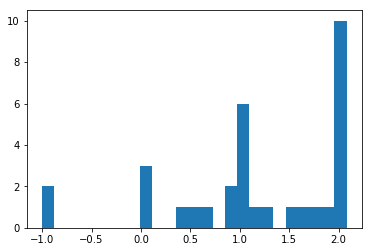

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [ 1.2975  0.4563  0.3794]]
4a9n:

real:
[[ 1.514   1.9077 -1.4783]
 [ 0.174   1.7917 -1.9773]
 [-0.051   1.5367 -3.3643]
 [-0.589   3.1577 -1.6003]]
fake:
[[ 1.6084  2.9833 -3.7863]
 [ 0.2684  2.8673 -4.2853]
 [ 0.0434  2.6123 -5.6723]
 [-0.4946  4.2333 -3.9083]]
fake:
[[ 0.9447  0.0914 -0.3151]
 [-0.2538 -0.4051 -0.8784]
 [-0.2079  0.9097 -0.3595]]
real dist:
[[  0.0000e+00   2.0581e+00   6.1439e+00   6.0000e+00]
 [  2.0581e+00   0.0000e+00   2.0394e+00   2.5903e+00]
 [  6.1439e+00   2.0394e+00   0.0000e+00   6.0288e+00]
 [  6.0000e+00   2.5903e+00   6.0288e+00  -1.9073e-06]]
fake dist:
[[  0.0000e+00   2.0581e+00   6.1439e+00   6.0000e+00]
 [  2.0581e+00  -3.8147e-06   2.0394e+00   2.5903e+00]
 [  6.1439e+00   2.0394e+00   0.0000e+00   6.0288e+00]
 [  6.0000e+00   2.5903e+00   6.0288e+00  -7.6294e-06]]
real rmsd:
[ 0.  0.  0.  0.  0.

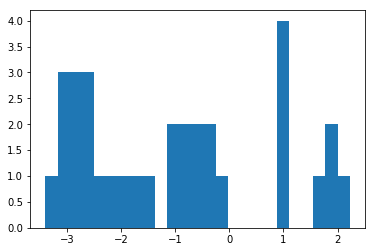

lam1:
-0.506502
/home/evan/Documents/deep_docking/datasets/v2015/4a9n/4a9n_ligand.mol2
[[ 5.4512  3.0005 -0.6985]
 [ 4.1112  2.8845 -1.1975]
 [ 3.8862  2.6295 -2.5845]
 [ 3.3482  4.2505 -0.8205]]
Butane:



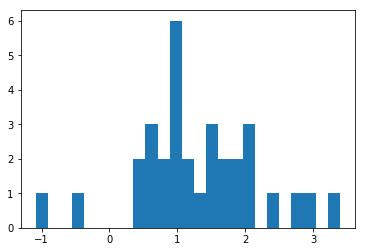

In [ ]:
every = 1000
train_dataset = features[:(len(features)-S+10)]
#train_dataset = features[0:8] + features[9:26] + features[29:36]
#train_dataset = features[:96*2]
n_train = len(train_dataset)

for it in range(1000000):
    a = time.time()
    random.shuffle(train_dataset)
    
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        

        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, D_loss_curr = sess.run(
            [D_solver, D_loss, clip_D] + d_ops, feed_dict=feed_dict)[0:2]
        
        _, G_loss_curr = sess.run([G_solver, G_loss] + g_ops, feed_dict=feed_dict)[0:2]
                
        #d_losses.append(D_loss_curr)
        #g_losses.append(G_loss_curr)
    
    if it % every == 0:
        
        print(time.time()-a)
        print("Training epoch %d" %it)
                
        print('Iter: {}'.format(it))
        #print('D loss: {:.4}'. format(D_loss_curr))
        #print('G_loss: {:.4}'.format(G_loss_curr))
        feed_dict = construct_feed_dict(features[3:4]*S, 0, S, shuffle_inds=False, keep_prob_val=1., train=False)
        
        print("4wks:\n")
        
        """
        print("real:")
        print(feed_dict[mol_xyz][0])
        print("fake:")
        print(sess.run(G_sample, feed_dict=feed_dict)[0])
        
        
        print("rot_points:")
        print(sess.run(rot_points, feed_dict=feed_dict))

        print("rot_vecs:")
        print(sess.run(rot_vecs, feed_dict=feed_dict))
        
        print("mol_gen_real:")
        print(sess.run(mol_gen_real, feed_dict=feed_dict))
        print("mol_gen_fake:")
        print(sess.run(mol_gen_fake, feed_dict=feed_dict))
        """
        

        print("generated rotation matrix:")
        print(sess.run(rot_mat_i, feed_dict=feed_dict))
        
        print("real dist:")
        print(sess.run(dist_fake_real, feed_dict=feed_dict)[0][:4, :4])
        print("fake dist:")
        print(sess.run(dist_fake_fake, feed_dict=feed_dict)[0][:4, :4])
        
        print("real rmsd:")
        print(sess.run(rmsds_real, feed_dict=feed_dict))
        print("fake rmsd:")
        print(sess.run(rmsds_fake, feed_dict=feed_dict))
        print(sess.run(dihed, feed_dict=feed_dict)[:, 0])

        print(np.mean(sess.run(dihed_tensor, feed_dict=feed_dict)[:, 0]))
        print(np.mean(sess.run(dihed, feed_dict=feed_dict)[:, 0]))
        
        plt.clf()
        plt.hist(sess.run(dihed, feed_dict=feed_dict)[:, 0], bins=25)
        plt.show()
        
        generate_molecule(features[3][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[3][0].split(".")[0].split("/")[-1], it))

        feed_dict = construct_feed_dict(features[0:1]*S, 0, S, shuffle_inds=False, keep_prob_val=1., train=False)
        print("4a9n:\n")
        
        print("real:")
        print(feed_dict[mol_xyz][0][:4])
        print("fake:")
        print(sess.run(G_sample, feed_dict=feed_dict)[0][:4])
        print("fake:")
        print(sess.run(rot_mat_i, feed_dict=feed_dict)[0])
        
        print("real dist:")
        print(sess.run(dist_fake_real, feed_dict=feed_dict)[0][:4, :4])
        print("fake dist:")
        print(sess.run(dist_fake_fake, feed_dict=feed_dict)[0][:4, :4])
        
        print("real rmsd:")
        print(sess.run(rmsds_real, feed_dict=feed_dict))
        print("fake rmsd:")
        print(sess.run(rmsds_fake, feed_dict=feed_dict))
    
        print(np.mean(sess.run(dihed_tensor, feed_dict=feed_dict)[:, 0]))
        print(np.mean(sess.run(dihed, feed_dict=feed_dict)[:, 0]))
        
        plt.clf()
        plt.hist(sess.run(dihed, feed_dict=feed_dict)[:, 0], bins=25)
        plt.show()
        
        print("lam1:")
        print(sess.run(lam1, feed_dict=feed_dict))
        
        generate_molecule(features[0][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[0][0].split(".")[0].split("/")[-1], it))
        print("Butane:\n")
        feed_dict = construct_feed_dict(features[len(features)-S:], 0, S, shuffle_inds=False, keep_prob_val=1., train=False)
        plt.clf()
        plt.hist(sess.run(dihed, feed_dict=feed_dict)[:, 0], bins=25)
        plt.show()
        #generate_molecule(features[1][0], sess.run(G_sample, feed_dict=feed_dict)[1], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[1][0].split(".")[0].split("/")[-1], it))

        #feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False, keep_prob_val=1.)
        #generate_molecule(features[-1][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[-1][0].split(".")[0].split("/")[-1], it))

        
        

        #print("output_i")
        #print(sess.run(G_sample_output_i, feed_dict=feed_dict))
        #print(sess.run(G_sample, feed_dict=feed_dict))

    #random.shuffle(train_dataset)



In [ ]:
np.where(features[27][4][3] == 1)

In [ ]:
features[27][3]

In [ ]:
every = 1000
#train_dataset = features[:96]
train_dataset = features[:1]*S
n_train = len(train_dataset)

for it in range(1000000):
    a = time.time()
    random.shuffle(train_dataset)
    
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        
        for _ in range(5):
            feed_dict = construct_feed_dict(train_dataset, start, stop)

            _, D_loss_curr, _ = sess.run(
                [D_solver, D_loss, clip_D], feed_dict=feed_dict)
        
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)
        
        d_losses.append(D_loss_curr)
        g_losses.append(G_loss_curr)
    
    if it % every == 0:
        
        print(time.time()-a)
        print("Training epoch %d" %it)
                
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        feed_dict = construct_feed_dict(features[:1]*S, 0, S, shuffle_inds=False, keep_prob_val=1.)
        
        print("4wks:\n")
        
        print("real:")
        print(feed_dict[mol_xyz][0][:4])
        print("fake:")
        print(sess.run(G_sample, feed_dict=feed_dict)[0][:4])
        print("fake:")
        print(sess.run(rot_mat_i, feed_dict=feed_dict))

        print(np.mean(sess.run(dihed, feed_dict=feed_dict)[:, 0]))
        plt.hist(sess.run(dihed, feed_dict=feed_dict)[:, 0])
        plt.show()
        
        
        generate_molecule(features[0][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[0][0].split(".")[0].split("/")[-1], it))
        
        print("Butane:\n")
        feed_dict = construct_feed_dict(features[len(features)-32:], 0, S, shuffle_inds=False, keep_prob_val=1.)
        plt.hist(sess.run(dihed, feed_dict=feed_dict)[:, 0])
        plt.show()
        #generate_molecule(features[1][0], sess.run(G_sample, feed_dict=feed_dict)[1], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[1][0].split(".")[0].split("/")[-1], it))

        #feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False, keep_prob_val=1.)
        #generate_molecule(features[-1][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[-1][0].split(".")[0].split("/")[-1], it))

        
        

        #print("output_i")
        #print(sess.run(G_sample_output_i, feed_dict=feed_dict))
        #print(sess.run(G_sample, feed_dict=feed_dict))

    #random.shuffle(train_dataset)



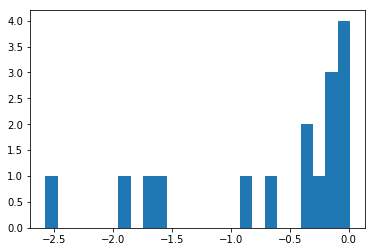

In [321]:
S=16
feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False)

plt.hist(np.squeeze(sess.run(dihed, feed_dict=feed_dict)), bins=25)
plt.show()

In [216]:
features[1]

('/home/evan/Documents/deep_docking/datasets/v2015/2ohk/2ohk_ligand.mol2',
 array([[-1.2731,  0.9987, -2.2001],
        [-0.5031,  1.0397, -1.0801],
        [-0.0411,  2.2447, -0.6841],
        [ 0.7269,  2.2857,  0.4109],
        [ 1.0309,  1.1747,  1.1729],
        [ 0.5309, -0.0663,  0.8089],
        [ 0.7909, -1.2213,  1.5379],
        [ 0.2719, -2.4343,  1.1299],
        [-0.4991, -2.5073, -0.0101],
        [-0.7681, -1.3733, -0.7401],
        [-0.2671, -0.1413, -0.3461],
        [ 0.    ,  0.    ,  0.    ]]),
 array([[[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]], dtype=uint8),
 array([[ 0.]]),
 array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0

In [ ]:
feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False)
generate_molecule(features[-1][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[-1][0].split(".")[0].split("/")[-1], it))


In [ ]:
np.min(results[0])



In [ ]:
np.where(features[0][1][:,:,:,:-1] == 1)

In [ ]:
"""
def discriminator(W_list, b_list, h_list, L_list, n_layers, mols):
    mols = tf.add(mols, mol_noise)
    with tf.device('/gpu:0'):
        for layer_idx in range(n_layers):
            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                             b_list[layer_idx], adj_list[layer_idx], 
                                             clades_list[layer_idx],
                                             L_list[layer_idx], L_list[layer_idx+1],
                                             layer_idx, S, B_list[layer_idx]), keep_prob))
        h_final = h_list[-1]
        dist_matrix = tf.concat([tf.reshape(compute_distance_matrix(tf.reshape(mol, [B, 3])), (1, B, B)) for mol in tf.split(mols, S, axis=0)], axis=0)
        print("dist_matrix")
        print(dist_matrix)
        #dist_matrix = compute_distance_matrix(mol)
        bond_dist_gen = tf.multiply(dist_matrix, adj_matrix)
        wrong_bond_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.square(tf.subtract(bond_dist_mat, bond_dist_gen)), axis=[1,2]), lam1), (S,1)), n_bonds)
        print("wrong_bond_loss")
        print(wrong_bond_loss)

        angles = []
        for i in range(0, B):
            for j in range(0, B):
                ij = mols[:, i,:] - mols[:,j,:]
                ij = ij / tf.sqrt(tf.reduce_sum(tf.square(ij), 1, keep_dims=True))
                #ij shape should be (S, 3)
               # print("ij")
                #print(ij)
                for k in range(0,B):
                    ik = mols[:,i,:] - mols[:,k,:]
                    ik = ik / tf.sqrt(tf.reduce_sum(tf.square(ik), 1, keep_dims=True))

                    #ik shape should be (S, 3)
                    #if i == 0 and j == 0 and k == 0: 
                    #   print("ik")
                     #   print(ik)
                        
                    dp = tf.reduce_sum(tf.multiply(ij, ik), axis=1, keep_dims=True)
                    #dp shape should be (S,1)
                    #if i ==0 and j ==0 and k==0:
                    #    print("dp")
                    #    print(dp)
                    if i == j or i == k or j == k:
                        angle = tf.Variable(tf.constant(np.zeros([4,1]).astype(np.float32)))
                    else:
                        angle = tf.acos(tf.clip_by_value(tf.reduce_sum(tf.multiply(ij, ik), axis=1, keep_dims=True), -1.0, 1.0))
                    #if i ==0 and j==0 and k==0:
                        #print("angle")
                        #print(angle)
                    angles.append(angle)
        angles_gen = tf.reshape(tf.concat(angles, axis=1), [S, B, B, B])
        angles_gen = tf.multiply(angles_gen, angle_tuples)
        wrong_angles_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.square(tf.subtract(angle_tensor, angles_gen)), axis=[1,2,3]), lam2), (S,1)), n_angles)
                
        feat_i = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_i = tf.tile(feat_i, [1, 1, B, 1])
        
        feat_j = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_j = tf.transpose(feat_j, perm=[0, 2, 1, 3])
        feat_j = tf.tile(feat_j, [1, B, 1, 1])
        
        d_h1 = tf.concat([tf.reshape(dist_matrix, [S, B, B, 1]), feat_i, feat_j], axis=3)
        d_h1 = tf.reshape(d_h1, [S, B, B*(L_list[n_layers]*2+1)])
        d_h2 = tf.nn.tanh(tf.matmul(d_h1, d_w1) + d_b1)
        d_h2 = tf.divide(tf.reduce_sum(tf.matmul(d_h2, d_w2) + d_b2, axis=1), n_bonds)#, axis=1
        print("d_h2")
        print(d_h2)
        
    
    return(wrong_bond_loss + wrong_angles_loss + d_h2, bond_dist_gen, angles_gen, wrong_bond_loss, wrong_angles_loss)
"""

In [ ]:
mol = Chem.MolFromMol2File(ligand_files[0])
c = mol.GetConformer(0)

In [ ]:
c.SetAtomPosition(0, [0., 0., 0.])

In [ ]:
np.where(features[2][1][:,:,:,:-1] == 1)

In [ ]:
results = sess.run(G_sample, feed_dict=feed_dict)

In [ ]:
sess.run(pred_real, feed_dict=feed_dict)

In [ ]:
np.max(results[0][:,:,:,:], axis=-1)

In [ ]:
features[1][0]

In [ ]:
mol = Chem.MolFromMol2File(features[1][0])
mol.GetNumAtoms()

In [ ]:
from rdkit.Chem import AllChem
AllChem.Compute2DCoords(mol)

In [ ]:
from rdkit.Chem import Draw

Draw.MolToImage(mol)